#### Import modules and read data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn import metrics
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold  #, RepeatedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [3]:
normal_data = pd.read_csv(os.getcwd() + '/Data/brain_tumour_normalized.csv')
normal_data.head()

,Image,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness,Class
0,Image1,0.194705,0.212023,0.443074,0.274801,0.068211,0.010937,0.028236,0.475410,0.246092,0.603108,0.139694,0.981764,0.0,0
1,Image2,0.261489,0.276124,0.510114,0.674843,0.052278,0.007693,0.017951,0.797096,0.648383,0.773800,0.093527,0.997417,0.0,0
2,Image3,0.219003,0.392326,0.614200,0.001487,0.090618,0.016478,0.023280,0.012719,0.001173,0.230760,0.195261,0.972855,0.0,1
3,Image4,0.177300,0.329007,0.559750,0.001513,0.108202,0.021559,0.043805,0.012908,0.001192,0.196137,0.258588,0.941475,0.0,1
4,Image5,0.218223,0.249840,0.483677,0.370574,0.068403,0.011067,0.050836,0.564860,0.338854,0.560862,0.226679,0.960995,0.0,0


In [4]:
X, Y = normal_data[normal_data.columns[1 : 14]], normal_data[normal_data.columns[-1]]
X.shape, Y.shape

((3762, 13), (3762,))

#### Feature Selection

Input variables are numeric, output variable is categorical. Hence, we use [ANOVA correlation coeff.](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)

In [5]:
k = 6

feature_selection = SelectKBest(score_func = f_classif, k = k)  # select k best features using ANOVA F-value

fit = feature_selection.fit(X, Y)

In [6]:
pd.DataFrame({'scores': fit.scores_, 'cols': X.columns}).sort_values(by = 'scores', ascending = False).head(k)  # k best features

,scores,cols
7,10913.518208,Energy
9,9587.758475,Homogeneity
3,5772.609943,Entropy
8,5086.027179,ASM
10,1685.254630,Dissimilarity
4,727.528516,Skewness


Get new X:

In [7]:
X_fs = feature_selection.transform(X)
X_fs.shape

(3762, 6)

#### Get ROC Curve, Accuracy, and Recall with k-best Feature Selection and n_splits-CV

In [8]:
def calcMetrics(model, name, n_splits = 5):
    cv = KFold(n_splits = n_splits, shuffle = True, random_state = 42)  # create CV splits
    
    fig, ax = plt.subplots()
    
    tprs, aucs, mean_fpr = [], [], np.linspace(0, 1, 100)  # true pos rates, area under curves, mean false pos rate
    acc_scores, recall_scores = [], []
    
    for i, (train, test) in enumerate(cv.split(X_fs, Y)):
        model.fit(X_fs[train], Y[train])  # train model
        
        Y_pred = model.predict(X_fs[test])  # get predictions
        
        # calc accuracy and sensitivity
        acc_scores.append(metrics.accuracy_score(Y[test], Y_pred))
        recall_scores.append(metrics.recall_score(Y[test], Y_pred))
        
        vis = metrics.plot_roc_curve(logisticRegr, X_fs[test], Y[test], name = 'ROC fold {}'.format(i), lw = 1, alpha = 0.3, ax = ax)  # plot ROC curve
    
        interp_tpr = np.interp(mean_fpr, vis.fpr, vis.tpr)  # interpolate true pos rate
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(vis.roc_auc)
        
    ax.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = '#ff0000', label = 'Chance', alpha = 0.5)

    mean_tpr = np.mean(tprs, axis = 0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)  # mean area under curve
    std_auc = np.std(aucs)  # auc std dev
    ax.plot(mean_fpr, mean_tpr, color = '#552583', label = r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc), lw = 2, alpha = 0.8)

    ax.set_title('ROC Curve: {}\nwith feature selection and 5-fold CV'.format(name))
    ax.legend()
    plt.tight_layout()
    plt.savefig(os.getcwd() + '/Graphs/featureSelection/' + name)
    plt.show()
    plt.close()
    
    acc_scores, recall_scores = np.array(acc_scores), np.array(recall_scores)
    print('Test accuracy:', acc_scores.mean() * 100)
    print('Test std. dev. of accuracy:', acc_scores.std())
    print('-' * 10)
    print('Test sensitivity:', recall_scores.mean() * 100)
    print('Test std. dev. of sensitivity:', recall_scores.std())

#### Logistic Regression

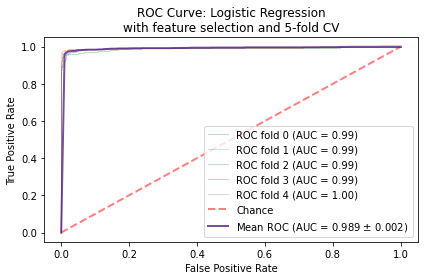

Test accuracy: 97.52800853324291
Test std. dev. of accuracy: 0.004866627819674722
----------
Test sensitivity: 95.28349912954982
Test std. dev. of sensitivity: 0.01096667022605552


In [9]:
logisticRegr = LogisticRegression()  # create model

calcMetrics(logisticRegr, 'Logistic Regression')

#### SVM - RBF

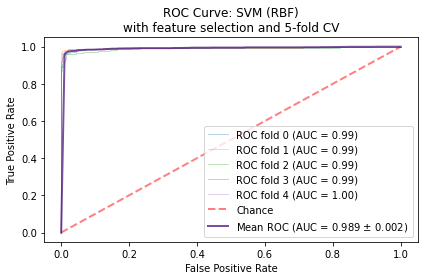

Test accuracy: 97.31538385465231
Test std. dev. of accuracy: 0.004849831900824604
----------
Test sensitivity: 94.80776739479074
Test std. dev. of sensitivity: 0.010584970781386635


In [10]:
svm_rbf = SVC(kernel = 'rbf', gamma = 'auto')  # create model

calcMetrics(svm_rbf, 'SVM (RBF)')

#### SVM - Sigmoid

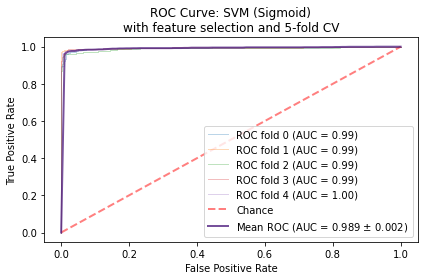

Test accuracy: 97.12935492074257
Test std. dev. of accuracy: 0.0038020758249501423
----------
Test sensitivity: 94.39304260642444
Test std. dev. of sensitivity: 0.009836992340566238


In [11]:
svm_sigmoid = SVC(kernel = 'sigmoid', gamma = 'auto')  # create model

calcMetrics(svm_sigmoid, 'SVM (Sigmoid)')

#### SVM - Linear

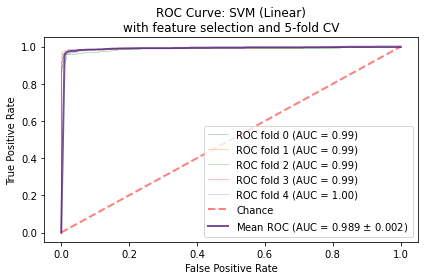

Test accuracy: 97.50141278856206
Test std. dev. of accuracy: 0.004630470360619991
----------
Test sensitivity: 95.22024382939563
Test std. dev. of sensitivity: 0.011126269549767042


In [12]:
svm_linear = SVC(kernel = 'linear', gamma = 'auto')  # create model

calcMetrics(svm_linear, 'SVM (Linear)')

#### Decision Tree

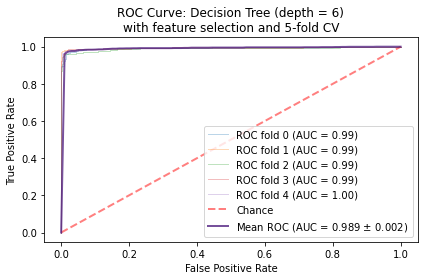

Test accuracy: 97.95332852985223
Test std. dev. of accuracy: 0.003520839384023229
----------
Test sensitivity: 96.64965273618958
Test std. dev. of sensitivity: 0.009603196706316765


In [13]:
depth = 6
dTree = DecisionTreeClassifier(criterion = 'gini', max_depth = depth)  # create model

calcMetrics(dTree, 'Decision Tree (depth = {})'.format(depth))

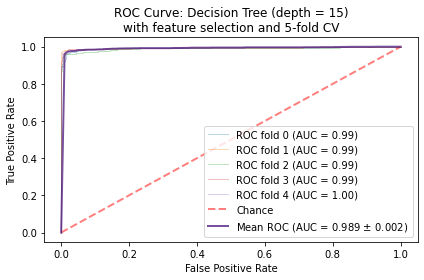

Test accuracy: 97.52811449238507
Test std. dev. of accuracy: 0.004484694095787334
----------
Test sensitivity: 97.12799837168596
Test std. dev. of sensitivity: 0.008002798695407041


In [14]:
depth = 15
dTree = DecisionTreeClassifier(criterion = 'gini', max_depth = depth)  # create model

calcMetrics(dTree, 'Decision Tree (depth = {})'.format(depth))

#### Naive Bayes

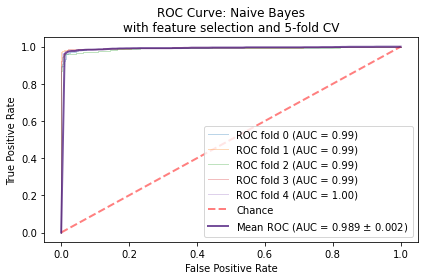

Test accuracy: 97.31545449408043
Test std. dev. of accuracy: 0.005198473005189852
----------
Test sensitivity: 94.80273736212362
Test std. dev. of sensitivity: 0.012450102739905447


In [15]:
naiveBayes = GaussianNB()  # create model

calcMetrics(naiveBayes, 'Naive Bayes')